In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import csv    
import gzip
from IPython.core.pylabtools import figsize
from IPython.display import clear_output
figsize(8, 8)
import re
import time
import os
import glob
%matplotlib inline               
from matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('ggplot')

# Unzipping the main file and its content

In [10]:
import tarfile
data_dir = os.listdir('/home/shubhamsingh/Desktop/files')
for subjectfile in data_dir:
    filename = '/home/shubhamsingh/Desktop/files/SMNI_CMI_TRAIN.tar.gz'
    tar = tarfile.open(filename)
    tar.extractall(path='/home/shubhamsingh/Desktop/files/newdata/')
    tar.close()

# Naming the locations 

In [82]:
main_dir = "/home/shubhamsingh/Desktop/files/"
eeg_data = os.path.join(main_dir+'newdata/SMNI_CMI_TRAIN/')  # unzipped subjects data file location

subject_files = os.listdir(eeg_data) # list all the subject folders

# Function to extract the information of a subject 

In [84]:
def extract_info(filename):
    """ Function to parse individual trial details for a subject.
        Args:
        filename - The name of file to be parsed
        
        Return:
        subject_id - The subject ID of the subject
        alcoholic - Return True for alcoholic subject
        stimulus  - Returns the stimulus for a particular trial
        trial_num - Trial number of the subject. On average there is 90 trial files per 
                    subject"""

    with gzip.open(filename, 'rt') as f:
        reader = csv.reader(f)
        for idx, row in enumerate(reader):
            if idx == 0:
                m = re.match('# (co\d(a|c)\d\d\d\d\d\d\d)', row[0])  #match pattern for the subject name
                                                                     #contains 'a' for alcoholics 
                                                                     #and 'c' for control
                subject_id = m.group(1)
                alcoholic = (m.group(2) == 'a')
            if idx == 3:
                m = re.match('# (.*?) trial (\d+)', row[0] + row[1]) #matching trial number 
                stimulus = re.sub('\W', ' ', m.group(1))
                trial_num = int(m.group(2))
#             if idx == 4:
#                 m = re.match('# (.*?) chan (\d+)', row[0])
#                 chan_name = re.sub('\W', '', m.group(1))
#                 chan_no = int(m.group(2))
    return subject_id, alcoholic, stimulus,trial_num

# Function to create convert files into csv format 

In [86]:
def create_csv(subject_folder, main_dir, verbosity):
    """
        This function reads in individual trial files of subject folder, stacks the data
        in the form of a dataframe object and writes them out as CSV files.
        
        Args:
        subject_folder: The folder containing all the unzipped trial files of a subject
        main_dir: The main directory path to the data location
        verbosity: Pass a number greater than 1 for more output details
        
        Return:
        None 
    """
    data_dir = main_dir + subject_folder
    print('##########################################################')
    print('Beginning extraction of subject ', str(subject_folder))
    trial_dir = os.listdir(data_dir)
    trial_files = [file_i for file_i in trial_dir if file_i.endswith('.gz')]
    print('There are ', len(trial_files), 'trials under this subject')
    for file_no, file in enumerate(trial_files):
        tic = time.time()
        filename = data_dir + file
        df = pd.DataFrame()
        if verbosity == 0:
            print('Beginning extraction from file ', filename)

        sub_id, whether_alc, what_stimulus, trial_no = extract_info(filename)
        if verbosity > 1:
            print('Beginning extraction of file: ', filename)
            print('Subject id:', sub_id, ' Trial No: ', trial_no)
        with gzip.open(filename, 'rt') as f:
            reader = csv.reader(f, delimiter=' ')
            for idx, row in enumerate(reader):
                if row[0] != '#':
                    df = df.append(pd.DataFrame([row],columns=list(['trial_num', 'chan_name', 'epoch','voltage'])))
                        
                
            df = pd.concat([df,pd.DataFrame(columns=['subject_id', 'stimulus', 'alcoholic'])],
                           ignore_index=True)
            df[['subject_id', 'stimulus','alcoholic']] = [sub_id, what_stimulus, whether_alc] 
                
            out_name = main_dir + 'newdata/'+'newdata/' + sub_id + '_' + str(
                    trial_no) + '.csv'
            df.to_csv(out_name, index=False, sep='\t', encoding='utf-8')
            toc = time.time()
            
            if verbosity == 0:
                print('CSV file saved as ', out_name)
            elif verbosity > 1:
                print('There are ', df.shape[0], ' rows and ', df.shape[1],
                        ' columns in this dataframe object')
                print('CSV file successully saved as ', out_name)
                print('It will take %f mins more for this subject!' %
                        round(((len(trial_files) - float(file_no+1)) * float((toc - tic) / 60.0)),2))
                print('-------------------------------------------------------------------------------')
    print('All files extracted and saved.')
    print('###########################################################')
    return None


# Unzipping the trial files of each subject and converting into .csv format 

In [93]:
len_trialfiles = []
for folder in subject_files:
    os.chdir(eeg_data+folder)
    zipped_files = [zipfile for zipfile in glob.glob(folder+'*.gz')]
    os.chdir(main_dir+'newdata/newdata')
    files = [file for file in glob.glob(folder+'*.csv')]
    len_trialfiles.append(len(zipped_files))
    ## check if all files are already extracted or not.
    if len(files) < len(zipped_files):
        create_csv("newdata/SMNI_CMI_TRAIN/"+folder+"/", main_dir, verbosity=5)
    else:
        print('All files satisfied for subject',folder,'; There are',len(files),'files.')

##########################################################
('Beginning extraction of subject ', 'newdata/SMNI_CMI_TRAIN/co2a0000377/')
('There are ', 30, 'trials under this subject')
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000377/co2a0000377.rd.032.gz')
('Subject id:', 'co2a0000377', ' Trial No: ', 32)


/home/shubhamsingh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:39: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000377_32.csv')
It will take 16.440000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000377/co2a0000377.rd.003.gz')
('Subject id:', 'co2a0000377', ' Trial No: ', 3)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000377_3.csv')
It will take 15.180000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000377/co2a0000377.rd.001.gz')
('Subject id:', 'co2a0000377', ' Trial No: ', 1)
('There are ', 16384,

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000377_45.csv')
It will take 6.670000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000377/co2a0000377.rd.071.gz')
('Subject id:', 'co2a0000377', ' Trial No: ', 71)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000377_71.csv')
It will take 6.140000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000377/co2a0000377.rd.031.gz')
('Subject id:', 'co2a0000377', ' Trial No: ', 31)
('There are ', 16384

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000337_26.csv')
It will take 13.880000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000337/co2c0000337.rd.033.gz')
('Subject id:', 'co2c0000337', ' Trial No: ', 33)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000337_33.csv')
It will take 13.340000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000337/co2c0000337.rd.029.gz')
('Subject id:', 'co2c0000337', ' Trial No: ', 29)
('There are ', 163

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000337_89.csv')
It will take 4.500000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000337/co2c0000337.rd.025.gz')
('Subject id:', 'co2c0000337', ' Trial No: ', 25)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000337_25.csv')
It will take 3.940000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000337/co2c0000337.rd.053.gz')
('Subject id:', 'co2c0000337', ' Trial No: ', 53)
('There are ', 16384

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000369_17.csv')
It will take 11.720000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000369/co2a0000369.rd.008.gz')
('Subject id:', 'co2a0000369', ' Trial No: ', 8)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000369_8.csv')
It will take 10.580000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000369/co2a0000369.rd.009.gz')
('Subject id:', 'co2a0000369', ' Trial No: ', 9)
('There are ', 16384,

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000369_29.csv')
It will take 2.260000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000369/co2a0000369.rd.011.gz')
('Subject id:', 'co2a0000369', ' Trial No: ', 11)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000369_11.csv')
It will take 1.690000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000369/co2a0000369.rd.000.gz')
('Subject id:', 'co2a0000369', ' Trial No: ', 0)
('There are ', 16384,

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000340_6.csv')
It will take 8.870000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000340/co2c0000340.rd.050.gz')
('Subject id:', 'co2c0000340', ' Trial No: ', 49)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000340_49.csv')
It will take 8.860000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000340/co2c0000340.rd.058.gz')
('Subject id:', 'co2c0000340', ' Trial No: ', 57)
('There are ', 16384,

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000340_18.csv')
It will take 0.000000 mins more for this subject!
-------------------------------------------------------------------------------
All files extracted and saved.
###########################################################
##########################################################
('Beginning extraction of subject ', 'newdata/SMNI_CMI_TRAIN/co2a0000375/')
('There are ', 30, 'trials under this subject')
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000375/co2a0000375.rd.022.gz')
('Subject id:', 'co2a0000375', ' Trial No: ', 22)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000375_22.csv')
It will take 16.110000 mins more for this subject!
---

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000375_17.csv')
It will take 7.220000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000375/co2a0000375.rd.006.gz')
('Subject id:', 'co2a0000375', ' Trial No: ', 6)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000375_6.csv')
It will take 6.280000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000375/co2a0000375.rd.041.gz')
('Subject id:', 'co2a0000375', ' Trial No: ', 41)
('There are ', 16384, 

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000344_45.csv')
It will take 14.340000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000344/co2c0000344.rd.025.gz')
('Subject id:', 'co2c0000344', ' Trial No: ', 25)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000344_25.csv')
It will take 13.850000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000344/co2c0000344.rd.012.gz')
('Subject id:', 'co2c0000344', ' Trial No: ', 12)
('There are ', 163

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000344_26.csv')
It will take 5.050000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000344/co2c0000344.rd.049.gz')
('Subject id:', 'co2c0000344', ' Trial No: ', 49)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000344_49.csv')
It will take 4.460000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000344/co2c0000344.rd.000.gz')
('Subject id:', 'co2c0000344', ' Trial No: ', 0)
('There are ', 16384,

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000364_27.csv')
It will take 12.350000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000364/co2a0000364.rd.012.gz')
('Subject id:', 'co2a0000364', ' Trial No: ', 12)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000364_12.csv')
It will take 11.730000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000364/co2a0000364.rd.031.gz')
('Subject id:', 'co2a0000364', ' Trial No: ', 31)
('There are ', 163

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000364_55.csv')
It will take 2.760000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000364/co2a0000364.rd.061.gz')
('Subject id:', 'co2a0000364', ' Trial No: ', 61)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000364_61.csv')
It will take 2.200000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000364/co2a0000364.rd.009.gz')
('Subject id:', 'co2a0000364', ' Trial No: ', 9)
('There are ', 16384,

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000371_11.csv')
It will take 10.430000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000371/co2a0000371.rd.000.gz')
('Subject id:', 'co2a0000371', ' Trial No: ', 0)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000371_0.csv')
It will take 8.780000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000371/co2a0000371.rd.019.gz')
('Subject id:', 'co2a0000371', ' Trial No: ', 19)
('There are ', 16384,

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000371_7.csv')
It will take 0.520000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000371/co2a0000371.rd.014.gz')
('Subject id:', 'co2a0000371', ' Trial No: ', 14)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000371_14.csv')
It will take 0.000000 mins more for this subject!
-------------------------------------------------------------------------------
All files extracted and saved.
###########################################################
##########################################################
('Beginning extraction of subject ', 'newdata/SMN

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000339_75.csv')
It will take 7.890000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000339/co2c0000339.rd.022.gz')
('Subject id:', 'co2c0000339', ' Trial No: ', 22)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000339_22.csv')
It will take 7.920000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000339/co2c0000339.rd.035.gz')
('Subject id:', 'co2c0000339', ' Trial No: ', 35)
('There are ', 16384

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000372_10.csv')
It will take 17.100000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000372/co2a0000372.rd.007.gz')
('Subject id:', 'co2a0000372', ' Trial No: ', 7)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000372_7.csv')
It will take 14.430000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000372/co2a0000372.rd.009.gz')
('Subject id:', 'co2a0000372', ' Trial No: ', 9)
('There are ', 16384,

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000372_29.csv')
It will take 5.660000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000372/co2a0000372.rd.027.gz')
('Subject id:', 'co2a0000372', ' Trial No: ', 27)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000372_27.csv')
It will take 5.090000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000372/co2a0000372.rd.047.gz')
('Subject id:', 'co2a0000372', ' Trial No: ', 47)
('There are ', 16384

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000342_19.csv')
It will take 19.150000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000342/co2c0000342.rd.014.gz')
('Subject id:', 'co2c0000342', ' Trial No: ', 14)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000342_14.csv')
It will take 13.410000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000342/co2c0000342.rd.015.gz')
('Subject id:', 'co2c0000342', ' Trial No: ', 15)
('There are ', 163

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000342_18.csv')
It will take 4.750000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000342/co2c0000342.rd.001.gz')
('Subject id:', 'co2c0000342', ' Trial No: ', 1)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000342_1.csv')
It will take 3.770000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000342/co2c0000342.rd.006.gz')
('Subject id:', 'co2c0000342', ' Trial No: ', 6)
('There are ', 16384, '

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000347_31.csv')
It will take 13.830000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000347/co2c0000347.rd.075.gz')
('Subject id:', 'co2c0000347', ' Trial No: ', 75)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000347_75.csv')
It will take 11.690000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000347/co2c0000347.rd.019.gz')
('Subject id:', 'co2c0000347', ' Trial No: ', 19)
('There are ', 163

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000347_14.csv')
It will take 1.540000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000347/co2c0000347.rd.008.gz')
('Subject id:', 'co2c0000347', ' Trial No: ', 8)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000347_8.csv')
It will take 0.600000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000347/co2c0000347.rd.002.gz')
('Subject id:', 'co2c0000347', ' Trial No: ', 2)
('There are ', 16384, '

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000378_25.csv')
It will take 8.850000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000378/co2a0000378.rd.003.gz')
('Subject id:', 'co2a0000378', ' Trial No: ', 3)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000378_3.csv')
It will take 8.620000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000378/co2a0000378.rd.013.gz')
('Subject id:', 'co2a0000378', ' Trial No: ', 13)
('There are ', 16384, 

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000365_47.csv')
It will take 18.140000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000365/co2a0000365.rd.061.gz')
('Subject id:', 'co2a0000365', ' Trial No: ', 61)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000365_61.csv')
It will take 20.130000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000365/co2a0000365.rd.012.gz')
('Subject id:', 'co2a0000365', ' Trial No: ', 12)
('There are ', 163

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000365_31.csv')
It will take 6.810000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000365/co2a0000365.rd.015.gz')
('Subject id:', 'co2a0000365', ' Trial No: ', 15)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000365_15.csv')
It will take 7.410000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000365/co2a0000365.rd.041.gz')
('Subject id:', 'co2a0000365', ' Trial No: ', 41)
('There are ', 16384

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000338_47.csv')
It will take 13.440000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000338/co2c0000338.rd.013.gz')
('Subject id:', 'co2c0000338', ' Trial No: ', 13)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000338_13.csv')
It will take 12.800000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000338/co2c0000338.rd.027.gz')
('Subject id:', 'co2c0000338', ' Trial No: ', 27)
('There are ', 163

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000338_2.csv')
It will take 3.740000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000338/co2c0000338.rd.017.gz')
('Subject id:', 'co2c0000338', ' Trial No: ', 17)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000338_17.csv')
It will take 3.370000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000338/co2c0000338.rd.000.gz')
('Subject id:', 'co2c0000338', ' Trial No: ', 0)
('There are ', 16384, 

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000341_33.csv')
It will take 11.110000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000341/co2c0000341.rd.014.gz')
('Subject id:', 'co2c0000341', ' Trial No: ', 14)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000341_14.csv')
It will take 10.580000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000341/co2c0000341.rd.011.gz')
('Subject id:', 'co2c0000341', ' Trial No: ', 11)
('There are ', 163

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000341_0.csv')
It will take 1.590000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000341/co2c0000341.rd.015.gz')
('Subject id:', 'co2c0000341', ' Trial No: ', 15)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000341_15.csv')
It will take 1.140000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000341/co2c0000341.rd.001.gz')
('Subject id:', 'co2c0000341', ' Trial No: ', 1)
('There are ', 16384, 

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000345_9.csv')
It will take 8.410000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000345/co2c0000345.rd.010.gz')
('Subject id:', 'co2c0000345', ' Trial No: ', 10)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000345_10.csv')
It will take 8.390000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000345/co2c0000345.rd.033.gz')
('Subject id:', 'co2c0000345', ' Trial No: ', 33)
('There are ', 16384,

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000370_5.csv')
It will take 15.510000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000370/co2a0000370.rd.015.gz')
('Subject id:', 'co2a0000370', ' Trial No: ', 15)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000370_15.csv')
It will take 15.550000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000370/co2a0000370.rd.014.gz')
('Subject id:', 'co2a0000370', ' Trial No: ', 14)
('There are ', 1638

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000370_41.csv')
It will take 6.910000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000370/co2a0000370.rd.012.gz')
('Subject id:', 'co2a0000370', ' Trial No: ', 12)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000370_12.csv')
It will take 6.200000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000370/co2a0000370.rd.037.gz')
('Subject id:', 'co2a0000370', ' Trial No: ', 37)
('There are ', 16384

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000368_16.csv')
It will take 13.990000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000368/co2a0000368.rd.001.gz')
('Subject id:', 'co2a0000368', ' Trial No: ', 1)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000368_1.csv')
It will take 12.590000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000368/co2a0000368.rd.011.gz')
('Subject id:', 'co2a0000368', ' Trial No: ', 11)
('There are ', 16384

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000368_10.csv')
It will take 5.330000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000368/co2a0000368.rd.071.gz')
('Subject id:', 'co2a0000368', ' Trial No: ', 71)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2a0000368_71.csv')
It will take 4.480000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2a0000368/co2a0000368.rd.037.gz')
('Subject id:', 'co2a0000368', ' Trial No: ', 37)
('There are ', 16384

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000346_28.csv')
It will take 12.070000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000346/co2c0000346.rd.009.gz')
('Subject id:', 'co2c0000346', ' Trial No: ', 9)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000346_9.csv')
It will take 10.920000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000346/co2c0000346.rd.015.gz')
('Subject id:', 'co2c0000346', ' Trial No: ', 15)
('There are ', 16384

('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000346_41.csv')
It will take 2.380000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000346/co2c0000346.rd.033.gz')
('Subject id:', 'co2c0000346', ' Trial No: ', 33)
('There are ', 16384, ' rows and ', 7, ' columns in this dataframe object')
('CSV file successully saved as ', '/home/shubhamsingh/Desktop/files/newdata/newdata/co2c0000346_33.csv')
It will take 1.810000 mins more for this subject!
-------------------------------------------------------------------------------
('Beginning extraction of file: ', '/home/shubhamsingh/Desktop/files/newdata/SMNI_CMI_TRAIN/co2c0000346/co2c0000346.rd.021.gz')
('Subject id:', 'co2c0000346', ' Trial No: ', 21)
('There are ', 16384

# Fetching the count of alcoholic and controlled subjects 

In [197]:
os.chdir("/home/shubhamsingh/Desktop/files/newdata/newdata")
alcoholics = [file for file in glob.glob('co2a*')]
controls = [file for file in glob.glob('co2c*')]

In [198]:
print('There are {} alcoholic and {} control subjects'.format(str(len(alcoholics)),str(len(controls))))

There are 300 alcoholic and 300 control subjects


# Data analysis on a single alcoholic and control subject file

In [187]:
os.chdir(main_dir+'newdata/newdata')
alcoholic_sub = alcoholics[4]       ## initialize the file 
control_sub = controls[4]
al_df = pd.read_csv(alcoholic_sub, delimiter='\t')       ## load into memory as a dataframe object
co_df = pd.read_csv(control_sub, delimiter='\t')

In [209]:
al_df.head()

,alcoholic,chan_name,epoch,stimulus,subject_id,trial_num,voltage
0,True,FP1,0,S2 nomatch,co2a0000368,35,-3.754
1,True,FP1,1,S2 nomatch,co2a0000368,35,-3.754
2,True,FP1,2,S2 nomatch,co2a0000368,35,-2.777
3,True,FP1,3,S2 nomatch,co2a0000368,35,0.153
4,True,FP1,4,S2 nomatch,co2a0000368,35,4.547


In [189]:
co_df.head()

,alcoholic,chan_name,epoch,stimulus,subject_id,trial_num,voltage
0,False,FP1,0,S1 obj,co2c0000339,30,4.862
1,False,FP1,1,S1 obj,co2c0000339,30,2.421
2,False,FP1,2,S1 obj,co2c0000339,30,0.468
3,False,FP1,3,S1 obj,co2c0000339,30,-0.509
4,False,FP1,4,S1 obj,co2c0000339,30,-0.509


# Function to create matrix of voltage corresponding to channels 

In [200]:
def make_matrix(df_obj):
    df = df_obj.loc[:, ['chan_name', 'voltage']] 
    chan_names = df_obj.chan_name.unique()
    z=[]
    for idx,chanel in enumerate(chan_names):
        voltages_values = df.loc[df['chan_name']== chanel]['voltage'].values
        z.append(voltages_values)
    z = np.array(z)
    return z.reshape(64,256)

# Function to plot the surface plot 

In [201]:

def make_surface_plot(X,Y,Z_al,Z_co,figtit):
    fig = plt.figure()
    #fig.colorbar(surf1,shrink=0.5, aspect=5)
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    X, Y = np.meshgrid(X, Y)
    surf = ax.plot_surface(X,Y, Z_al, cmap='RdBu_r',
                           linewidth=0, antialiased=False)
    ax.set_xlabel('epoch')
    ax.set_ylabel('channels')
    ax.set_zlabel('Voltages(micro volts)')
    ax.text2D(0.05,0.95, "Alcoholic "+figtit,transform=ax.transAxes)

    #fig.colorbar(surf, shrink=0.5, aspect=5)

    ax.view_init(elev=40., azim=320)

    ax1 = fig.add_subplot(1, 2, 2, projection='3d')
    
    surf1 = ax1.plot_surface(X,Y, Z_co, cmap='RdBu_r',
                           linewidth=0, antialiased=False)
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('channels')
    ax1.set_zlabel('Voltages(micro volts)')
    ax1.text2D(0.05,0.95, "Control "+figtit,transform=ax1.transAxes)
    ax1.view_init(elev=40., azim=320)
    #fig.colorbar(surf1,shrink=0.5, aspect=5)
    cax = fig.add_axes([0.49, 0.1, 0.03, 0.8])
    fig.colorbar(surf1,cax=cax)
    fig.set_size_inches(20,8)
    plt.show()


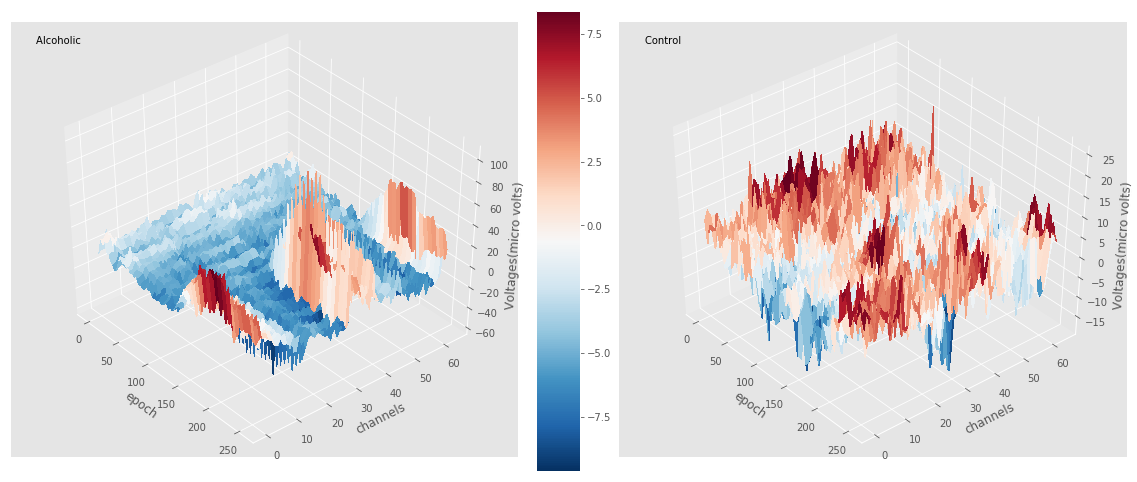

In [202]:
X = np.arange(0, 256, 1)
Y = np.arange(0,64, 1)
Z_al = make_matrix(al_df)
Z_co = make_matrix(co_df)
make_surface_plot(X,Y,Z_al,Z_co,'')